# Base Preprocessing Pipeline for Flight Delay Data

This notebook implements the fundamental preprocessing steps required for flight delay data that are common across all model types (Machine Learning, Deep Learning, and Time Series). These operations set the foundation for further specialized preprocessing.

## Key Processing Steps:
1. Loading and initial inspection of the data
2. Filtering out 2020 data due to COVID-19 irregularities
3. Basic data cleaning and type conversions
4. Detecting and removing duplicate records
5. Handling missing values
6. Feature derivation that benefits all model types
7. Saving the preprocessed data for downstream pipelines

In [1]:
# Install and import required libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Configure paths dynamically using relative paths
import os.path as path

# Get the directory of the current notebook
notebook_dir = path.dirname(path.abspath('__file__'))
# Get project root (parent of notebooks directory)
project_root = path.abspath(path.join(notebook_dir, '..', '..'))

# Define paths relative to project root
RAW_DATA_PATH = path.join(project_root, 'data', 'raw', 'flights_sample_3m.csv')
PROCESSED_DATA_PATH = path.join(project_root, 'data', 'processed')

# Create processed data directory if it doesn't exist
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
print(f"Raw data path: {RAW_DATA_PATH}")
print(f"Processed data path: {PROCESSED_DATA_PATH}")

# Display settings
pd.set_option('display.max_columns', None)
print("Libraries and paths configured.")

Raw data path: /Users/osx/flightDelayPIPELINE.2/data/raw/flights_sample_3m.csv
Processed data path: /Users/osx/flightDelayPIPELINE.2/data/processed
Libraries and paths configured.


In [2]:
# Function to load data in chunks and allow basic processing
def load_data_in_chunks(file_path, chunk_size=500000, filter_2020=True):
    """
    Generator function to load data in chunks with basic filtering
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file
    chunk_size : int
        Number of rows to load in each chunk
    filter_2020 : bool
        Whether to remove flights from 2020 due to COVID-19 irregularities
    
    Yields:
    -------
    pd.DataFrame
        Processed chunk of data
    """
    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Convert date columns to datetime
        date_columns = [col for col in chunk.columns if 'DATE' in col.upper()]
        for col in date_columns:
            chunk[col] = pd.to_datetime(chunk[col], errors='coerce')
        
        # Filter out 2020 data if specified
        if filter_2020:
            year_column = None
            # Find the best column with date information
            for col in date_columns:
                if chunk[col].dt.year.nunique() > 0:
                    year_column = col
                    break
            
            if year_column:
                # Filter out 2020 data
                chunk = chunk[chunk[year_column].dt.year != 2020]
        
        yield chunk

In [3]:
# Inspect the data
first_chunk = next(load_data_in_chunks(RAW_DATA_PATH))

print(f"Data shape of first chunk: {first_chunk.shape}")
print("\nColumns and data types:")
for col in first_chunk.columns:
    print(f"- {col}: {first_chunk[col].dtype}")

print("\nSample data (first 5 rows):")
display(first_chunk.head())

# Check unique years in the dataset
if 'FL_DATE' in first_chunk.columns:
    print("\nYears in the dataset:")
    print(first_chunk['FL_DATE'].dt.year.value_counts().sort_index())

Data shape of first chunk: (420601, 32)

Columns and data types:
- FL_DATE: datetime64[ns]
- AIRLINE: object
- AIRLINE_DOT: object
- AIRLINE_CODE: object
- DOT_CODE: int64
- FL_NUMBER: int64
- ORIGIN: object
- ORIGIN_CITY: object
- DEST: object
- DEST_CITY: object
- CRS_DEP_TIME: int64
- DEP_TIME: float64
- DEP_DELAY: float64
- TAXI_OUT: float64
- WHEELS_OFF: float64
- WHEELS_ON: float64
- TAXI_IN: float64
- CRS_ARR_TIME: int64
- ARR_TIME: float64
- ARR_DELAY: float64
- CANCELLED: float64
- CANCELLATION_CODE: object
- DIVERTED: float64
- CRS_ELAPSED_TIME: float64
- ELAPSED_TIME: float64
- AIR_TIME: float64
- DISTANCE: float64
- DELAY_DUE_CARRIER: float64
- DELAY_DUE_WEATHER: float64
- DELAY_DUE_NAS: float64
- DELAY_DUE_SECURITY: float64
- DELAY_DUE_LATE_AIRCRAFT: float64

Sample data (first 5 rows):


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",1155,1151.0,-4.0,19.0,1210.0,1443.0,4.0,1501,1447.0,-14.0,0.0,NaN,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",2120,2114.0,-6.0,9.0,2123.0,2232.0,38.0,2315,2310.0,-5.0,0.0,NaN,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",954,1000.0,6.0,20.0,1020.0,1247.0,5.0,1252,1252.0,0.0,0.0,NaN,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",1609,1608.0,-1.0,27.0,1635.0,1844.0,9.0,1829,1853.0,24.0,0.0,NaN,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
5,2019-07-31,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,665,DAL,"Dallas, TX",OKC,"Oklahoma City, OK",1010,1237.0,147.0,15.0,1252.0,1328.0,3.0,1110,1331.0,141.0,0.0,NaN,0.0,60.0,54.0,36.0,181.0,141.0,0.0,0.0,0.0,0.0



Years in the dataset:
FL_DATE
2019    126691
2021    101646
2022    114644
2023     77620
Name: count, dtype: int64


Total number of rows (after filtering 2020): 2,520,650

Missing value analysis:


,Column,Missing Values,Missing Percentage
21,CANCELLATION_CODE,2470267,98.001190
31,DELAY_DUE_LATE_AIRCRAFT,2030858,80.568822
30,DELAY_DUE_SECURITY,2030858,80.568822
29,DELAY_DUE_NAS,2030858,80.568822
28,DELAY_DUE_WEATHER,2030858,80.568822
27,DELAY_DUE_CARRIER,2030858,80.568822
25,AIR_TIME,56671,2.248269
24,ELAPSED_TIME,56671,2.248269
19,ARR_DELAY,56671,2.248269
15,WHEELS_ON,51112,2.027731


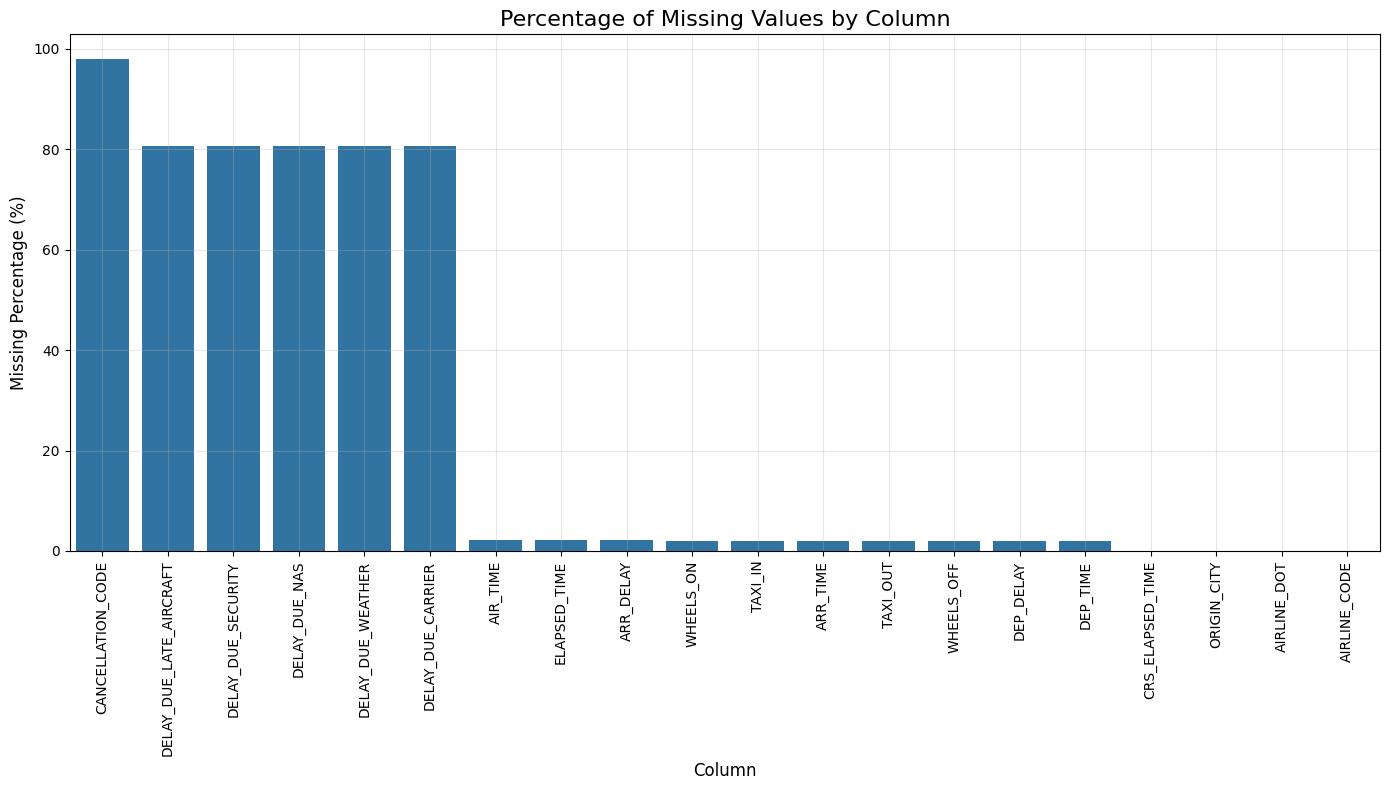

In [4]:
# Function to analyze missing values
def analyze_missing_values(chunks):
    """Analyze missing values across all chunks"""
    missing_counts = {}
    total_rows = 0
    
    for chunk in chunks:
        total_rows += len(chunk)
        for col in chunk.columns:
            missing = chunk[col].isna().sum()
            missing_counts[col] = missing_counts.get(col, 0) + missing
    
    missing_df = pd.DataFrame({
        'Column': list(missing_counts.keys()),
        'Missing Values': list(missing_counts.values()),
        'Missing Percentage': [count/total_rows*100 for count in missing_counts.values()]
    }).sort_values('Missing Percentage', ascending=False)
    
    return missing_df, total_rows

# Analyze missing values
missing_df, total_rows = analyze_missing_values(load_data_in_chunks(RAW_DATA_PATH))

print(f"Total number of rows (after filtering 2020): {total_rows:,}")
print("\nMissing value analysis:")
display(missing_df)

# Visualize missing values
plt.figure(figsize=(14, 8))
sns.barplot(x='Column', y='Missing Percentage', data=missing_df.head(20))
plt.title('Percentage of Missing Values by Column', fontsize=16)
plt.xlabel('Column', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Base Preprocessing Functions

Below are the core functions that will be used in the base preprocessing pipeline. These functions handle the fundamental data processing tasks that are common across all model types.

In [5]:
# Define essential columns for all model types
def identify_essential_columns(df):
    """
    Identify essential columns that should be kept across all model types.
    This function helps remove unnecessary columns early in the pipeline.
    """
    # Column groups to keep
    essential_columns = [
        # Identifiers and dates
        'FL_DATE', 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
        
        # Flight information
        'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME',
        'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 
        
        # Arrival information
        'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
        
        # Additional useful information
        'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
        'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
        'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'
    ]
    
    # Keep only columns that exist in the dataframe
    existing_columns = [col for col in essential_columns if col in df.columns]
    
    return existing_columns

In [6]:
# Clean and convert data types
def clean_and_convert_types(df):
    """
    Clean the dataframe and convert data types for efficiency
    """
    df_cleaned = df.copy()
    
    # Convert time fields to proper format if they're not already datetime
    time_columns = ['DEP_TIME', 'CRS_DEP_TIME', 'ARR_TIME', 'CRS_ARR_TIME']
    for col in time_columns:
        if col in df_cleaned.columns and not pd.api.types.is_datetime64_dtype(df_cleaned[col]):
            # Handle time as integer in HHMM format
            try:
                # Convert times like 1030 (10:30 AM) to proper time format
                df_cleaned[col] = df_cleaned[col].astype(float)
                df_cleaned[col] = (df_cleaned[col] // 100).astype(int) * 60 + (df_cleaned[col] % 100).astype(int)
            except:
                pass
    
    # Convert categorical columns to category type
    categorical_cols = ['OP_CARRIER', 'ORIGIN', 'DEST', 'CANCELLATION_CODE']
    for col in categorical_cols:
        if col in df_cleaned.columns:
            df_cleaned[col] = df_cleaned[col].astype('category')
    
    # Convert boolean columns to boolean type
    binary_cols = ['CANCELLED', 'DIVERTED']
    for col in binary_cols:
        if col in df_cleaned.columns:
            df_cleaned[col] = df_cleaned[col].astype(bool)
    
    return df_cleaned

In [7]:
# Handle missing values - approach consistent across all model types
def handle_missing_values(df):
    """
    Handle missing values with strategies that work for all model types
    """
    df_processed = df.copy()
    
    # Delay columns - replace missing values with 0 (no delay)
    delay_columns = ['DEP_DELAY', 'ARR_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 
                     'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
    
    for col in delay_columns:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].fillna(0)
    
    # Time columns - use scheduled time if actual time is missing
    if 'DEP_TIME' in df_processed.columns and 'CRS_DEP_TIME' in df_processed.columns:
        df_processed['DEP_TIME'] = df_processed['DEP_TIME'].fillna(df_processed['CRS_DEP_TIME'])
    
    if 'ARR_TIME' in df_processed.columns and 'CRS_ARR_TIME' in df_processed.columns:
        df_processed['ARR_TIME'] = df_processed['ARR_TIME'].fillna(df_processed['CRS_ARR_TIME'])
    
    # Elapsed time and air time
    if 'CRS_ELAPSED_TIME' in df_processed.columns and 'ACTUAL_ELAPSED_TIME' in df_processed.columns:
        df_processed['ACTUAL_ELAPSED_TIME'] = df_processed['ACTUAL_ELAPSED_TIME'].fillna(df_processed['CRS_ELAPSED_TIME'])
    
    # For cancelled or diverted flights, some fields are expected to be missing
    # Leave those missing for now - specialized pipelines will handle them according to model needs
    
    return df_processed

In [8]:
# Create common derived features useful for all model types
def create_common_features(df):
    """
    Create new features that are beneficial across all model types
    """
    df_featured = df.copy()
    
    # Extract time components if we have FL_DATE
    if 'FL_DATE' in df_featured.columns:
        # Extract date components if not already present
        if 'YEAR' not in df_featured.columns:
            df_featured['YEAR'] = df_featured['FL_DATE'].dt.year
        if 'MONTH' not in df_featured.columns:
            df_featured['MONTH'] = df_featured['FL_DATE'].dt.month
        if 'DAY_OF_MONTH' not in df_featured.columns:
            df_featured['DAY_OF_MONTH'] = df_featured['FL_DATE'].dt.day
        if 'DAY_OF_WEEK' not in df_featured.columns:
            df_featured['DAY_OF_WEEK'] = df_featured['FL_DATE'].dt.dayofweek + 1  # 1-based (1=Monday)
        
        # Create quarter if not present
        if 'QUARTER' not in df_featured.columns:
            df_featured['QUARTER'] = df_featured['FL_DATE'].dt.quarter
        
        # Create season
        df_featured['SEASON'] = df_featured['MONTH'].apply(lambda x: 
            1 if x in [12, 1, 2] else  # Winter
            2 if x in [3, 4, 5] else   # Spring
            3 if x in [6, 7, 8] else   # Summer
            4                          # Fall
        )
        
        # Is holiday season flag (November-December)
        df_featured['IS_HOLIDAY_SEASON'] = df_featured['MONTH'].isin([11, 12]).astype(int)
    
    # Extract hour from departure time if available and in the right format
    if 'CRS_DEP_TIME' in df_featured.columns:
        try:
            # If it's in minutes format (converted earlier)
            if df_featured['CRS_DEP_TIME'].dtype != 'object':
                df_featured['DEP_HOUR'] = df_featured['CRS_DEP_TIME'] // 60
            # If it's in HHMM format
            else:
                df_featured['DEP_HOUR'] = df_featured['CRS_DEP_TIME'].astype(str).str[:2].astype(float)
            
            # Time of day category
            df_featured['TIME_OF_DAY'] = pd.cut(
                df_featured['DEP_HOUR'], 
                bins=[0, 6, 12, 18, 24], 
                labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                right=False
            )
        except:
            print("Could not create time of day features from CRS_DEP_TIME")
    
    # Create binary indicators for cancelled and diverted flights
    if 'CANCELLED' in df_featured.columns and df_featured['CANCELLED'].dtype == bool:
        df_featured['CANCELLED'] = df_featured['CANCELLED'].astype(int)
    
    if 'DIVERTED' in df_featured.columns and df_featured['DIVERTED'].dtype == bool:
        df_featured['DIVERTED'] = df_featured['DIVERTED'].astype(int)
    
    # Calculate scheduled departure and arrival times in minutes since midnight
    # This is more useful for models than HHMM format
    if 'CRS_DEP_TIME' in df_featured.columns:
        try:
            if isinstance(df_featured['CRS_DEP_TIME'].iloc[0], (int, float)):
                if df_featured['CRS_DEP_TIME'].max() > 2400:  # Already in minutes
                    df_featured['CRS_DEP_TIME_MINUTES'] = df_featured['CRS_DEP_TIME']
                else:  # HHMM format
                    df_featured['CRS_DEP_TIME_MINUTES'] = (df_featured['CRS_DEP_TIME'] // 100) * 60 + (df_featured['CRS_DEP_TIME'] % 100)
        except:
            print("Could not convert CRS_DEP_TIME to minutes")
    
    if 'CRS_ARR_TIME' in df_featured.columns:
        try:
            if isinstance(df_featured['CRS_ARR_TIME'].iloc[0], (int, float)):
                if df_featured['CRS_ARR_TIME'].max() > 2400:  # Already in minutes
                    df_featured['CRS_ARR_TIME_MINUTES'] = df_featured['CRS_ARR_TIME']
                else:  # HHMM format
                    df_featured['CRS_ARR_TIME_MINUTES'] = (df_featured['CRS_ARR_TIME'] // 100) * 60 + (df_featured['CRS_ARR_TIME'] % 100)
        except:
            print("Could not convert CRS_ARR_TIME to minutes")
    
    return df_featured

In [9]:
# Handle duplicate records
def handle_duplicates(df):
    """
    Identify and handle duplicate records in the dataset
    """
    # Check if we have key flight identifiers
    key_cols = []
    
    # Flight date
    if 'FL_DATE' in df.columns:
        key_cols.append('FL_DATE')
        
    # Flight identifiers
    if 'OP_CARRIER' in df.columns and 'OP_CARRIER_FL_NUM' in df.columns:
        key_cols.extend(['OP_CARRIER', 'OP_CARRIER_FL_NUM'])
    
    # Origin and destination
    if 'ORIGIN' in df.columns and 'DEST' in df.columns:
        key_cols.extend(['ORIGIN', 'DEST'])
    
    # Departure time
    if 'DEP_TIME' in df.columns or 'CRS_DEP_TIME' in df.columns:
        dep_time_col = 'DEP_TIME' if 'DEP_TIME' in df.columns else 'CRS_DEP_TIME'
        key_cols.append(dep_time_col)
    
    # Count duplicates before removal
    if key_cols:
        dup_count = df.duplicated(subset=key_cols, keep=False).sum()
        if dup_count > 0:
            print(f"Found {dup_count} duplicate records based on {key_cols}")
            
            # Remove duplicates
            df_dedup = df.drop_duplicates(subset=key_cols, keep='first')
            print(f"Removed {len(df) - len(df_dedup)} duplicate records")
            return df_dedup
    
    return df

# Process a chunk with all base preprocessing steps
def preprocess_chunk_base(chunk):
    """
    Apply all base preprocessing steps to a chunk of data
    """
    # Get only essential columns
    essential_cols = identify_essential_columns(chunk)
    df = chunk[essential_cols].copy()
    
    # Clean and convert types
    df = clean_and_convert_types(df)
    
    # Handle duplicate records
    df = handle_duplicates(df)
    
    # Handle missing values
    df = handle_missing_values(df)
    
    # Create common features
    df = create_common_features(df)
    
    return df

## Execute the Base Preprocessing Pipeline

Now we'll run the complete base preprocessing pipeline on the entire dataset, processing the data in chunks to handle the large file size.

In [10]:
# Process all chunks and save the result
def process_and_save_base_preprocessed_data(input_file, output_file, chunk_size=500000):
    """
    Process all chunks and save the result to a file
    """
    # Process in chunks to handle large files
    chunks = []
    total_chunks = 0
    total_rows = 0
    
    print(f"Starting preprocessing of {input_file}...")
    
    for i, chunk in enumerate(load_data_in_chunks(input_file, chunk_size=chunk_size)):
        start_time = datetime.now()
        
        # Apply preprocessing
        processed_chunk = preprocess_chunk_base(chunk)
        
        # Append the processed chunk
        chunks.append(processed_chunk)
        total_chunks += 1
        total_rows += len(processed_chunk)
        
        # Print progress
        end_time = datetime.now()
        elapsed = (end_time - start_time).total_seconds()
        print(f"Processed chunk {i+1}: {len(processed_chunk):,} rows in {elapsed:.2f} seconds")
        
        # To save memory, periodically combine and save chunks
        if len(chunks) >= 5:
            combined = pd.concat(chunks)
            
            # Save with mode='a' (append) after first chunk
            if i <= 5:
                combined.to_csv(output_file, index=False)
            else:
                combined.to_csv(output_file, mode='a', header=False, index=False)
                
            # Clear chunks list to free memory
            chunks = []
            print(f"Saved batch to {output_file}, total rows so far: {total_rows:,}")
    
    # Save any remaining chunks
    if chunks:
        combined = pd.concat(chunks)
        # Check if file exists
        if os.path.exists(output_file):
            combined.to_csv(output_file, mode='a', header=False, index=False)
        else:
            combined.to_csv(output_file, index=False)
    
    print(f"Base preprocessing complete! Processed {total_chunks} chunks with {total_rows:,} total rows")
    print(f"Output saved to {output_file}")
    
    return total_rows

In [11]:
# Execute the pipeline
output_file = os.path.join(PROCESSED_DATA_PATH, 'base_preprocessed_flights.csv')
total_processed = process_and_save_base_preprocessed_data(RAW_DATA_PATH, output_file)

Starting preprocessing of /Users/osx/flightDelayPIPELINE.2/data/raw/flights_sample_3m.csv...
Found 201 duplicate records based on ['FL_DATE', 'ORIGIN', 'DEST', 'DEP_TIME']
Removed 101 duplicate records
Processed chunk 1: 420,500 rows in 0.84 seconds
Found 210 duplicate records based on ['FL_DATE', 'ORIGIN', 'DEST', 'DEP_TIME']
Removed 106 duplicate records
Processed chunk 2: 420,221 rows in 0.57 seconds
Found 221 duplicate records based on ['FL_DATE', 'ORIGIN', 'DEST', 'DEP_TIME']
Removed 111 duplicate records
Processed chunk 3: 419,752 rows in 0.60 seconds
Found 206 duplicate records based on ['FL_DATE', 'ORIGIN', 'DEST', 'DEP_TIME']
Removed 105 duplicate records
Processed chunk 4: 419,754 rows in 0.58 seconds
Found 223 duplicate records based on ['FL_DATE', 'ORIGIN', 'DEST', 'DEP_TIME']
Removed 114 duplicate records
Processed chunk 5: 420,182 rows in 0.56 seconds
Saved batch to /Users/osx/flightDelayPIPELINE.2/data/processed/base_preprocessed_flights.csv, total rows so far: 2,100,409

In [12]:
# Verify the output file
try:
    # Read a sample of the processed data
    processed_sample = pd.read_csv(output_file, nrows=1000)
    print(f"Processed data shape: {processed_sample.shape}")
    print("\nColumns in processed data:")
    for col in processed_sample.columns:
        print(f"- {col}: {processed_sample[col].dtype}")
    
    print("\nSample of processed data:")
    display(processed_sample.head())
    
    # Check if key derived features are present
    expected_features = ['SEASON', 'TIME_OF_DAY', 'IS_HOLIDAY_SEASON']
    present_features = [col for col in expected_features if col in processed_sample.columns]
    print(f"\nNew derived features created: {present_features}")
    
except Exception as e:
    print(f"Error reading processed file: {e}")

Processed data shape: (1000, 28)

Columns in processed data:
- FL_DATE: object
- ORIGIN: object
- DEST: object
- CRS_DEP_TIME: int64
- DEP_TIME: float64
- DEP_DELAY: float64
- TAXI_OUT: float64
- WHEELS_OFF: float64
- WHEELS_ON: float64
- TAXI_IN: float64
- CRS_ARR_TIME: int64
- ARR_TIME: float64
- ARR_DELAY: float64
- CANCELLED: int64
- CANCELLATION_CODE: object
- DIVERTED: int64
- CRS_ELAPSED_TIME: float64
- AIR_TIME: float64
- DISTANCE: float64
- YEAR: int64
- MONTH: int64
- DAY_OF_MONTH: int64
- DAY_OF_WEEK: int64
- QUARTER: int64
- SEASON: int64
- IS_HOLIDAY_SEASON: int64
- DEP_HOUR: int64
- TIME_OF_DAY: object

Sample of processed data:


,FL_DATE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,AIR_TIME,DISTANCE,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,QUARTER,SEASON,IS_HOLIDAY_SEASON,DEP_HOUR,TIME_OF_DAY
0,2019-01-09,FLL,EWR,715,1151.0,-4.0,19.0,1210.0,1443.0,4.0,901,1447.0,-14.0,0,NaN,0,186.0,153.0,1065.0,2019,1,9,3,1,1,0,11,Morning
1,2022-11-19,MSP,SEA,1280,2114.0,-6.0,9.0,2123.0,2232.0,38.0,1395,2310.0,-5.0,0,NaN,0,235.0,189.0,1399.0,2022,11,19,6,4,4,1,21,Evening
2,2022-07-22,DEN,MSP,594,1000.0,6.0,20.0,1020.0,1247.0,5.0,772,1252.0,0.0,0,NaN,0,118.0,87.0,680.0,2022,7,22,5,3,3,0,9,Morning
3,2023-03-06,MSP,SFO,969,1608.0,-1.0,27.0,1635.0,1844.0,9.0,1109,1853.0,24.0,0,NaN,0,260.0,249.0,1589.0,2023,3,6,1,1,2,0,16,Afternoon
4,2019-07-31,DAL,OKC,610,1237.0,147.0,15.0,1252.0,1328.0,3.0,670,1331.0,141.0,0,NaN,0,60.0,36.0,181.0,2019,7,31,3,3,3,0,10,Morning



New derived features created: ['SEASON', 'TIME_OF_DAY', 'IS_HOLIDAY_SEASON']


## Summary of Base Preprocessing

The base preprocessing pipeline has:

1. Removed data from 2020 due to COVID-19 irregularities
2. Selected essential columns for all model types
3. Converted data types for efficiency and consistency
4. Detected and removed duplicate flight records
5. Handled missing values with strategies that work across all model types
6. Created common derived features beneficial for all analyses
7. Processed the data in chunks to handle the large dataset
8. Saved the result for use by specialized pipelines

This base processed dataset serves as the foundation for more specialized preprocessing pipelines tailored to different model types (ML, DL, Time Series).